In [1]:
#All Imports

import copy
import h5py
import io
import json
import numpy as np
import os
import pandas as pd
import pickle
import time
from collections import OrderedDict

from keras.models import load_model
from keras.models import clone_model
from google.protobuf.json_format import ParseDict

from esp_sdk.v1_0.esp_persistor import EspPersistor
from esp_sdk.v1_0.esp_service import EspService

from data_util.data_set_encoder import DataSetEncoder
from data_util.evaluator import Evaluator
print ("ALL IMPORTS COMPLETED !!!!!!")

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


ALL IMPORTS COMPLETED !!!!!!


In [2]:
#File name definitions

DATA_PATH = "./data_context5"

In [3]:
#Context, Actions and Outcomes column names

CONTEXT_CSV = os.path.join(DATA_PATH, "context.csv")
ACTIONS_CSV = os.path.join(DATA_PATH, "actions.csv")
OUTCOMES_CSV = os.path.join(DATA_PATH, "outcomes.csv")
POSSIBLE_VALUES_CSV = os.path.join(DATA_PATH, "possible_values.csv")

In [4]:
#Evaluation samples: samples we want to use to evaluate a candidate

EVALUATION_SAMPLES_CSV =  os.path.join(DATA_PATH, "splits/70-30/val_set_0.csv")

In [5]:
PRESCRIPTOR_JSON = os.path.join(DATA_PATH, "prescriptor.json")
PRESCRIPTOR_H5 = os.path.join(DATA_PATH, 'prescriptor.h5')
PREDICTOR_H5 = os.path.join(DATA_PATH, "predictor.h5")

In [6]:
#Output directory to store training results

TRAINED_PRESCRIPTORS_DIR = "trained_prescriptors/"

In [7]:
#Read Context, Action and Outcome files and possible values

with open(POSSIBLE_VALUES_CSV) as csv_file:
    possible_values_df = pd.read_csv(csv_file, sep=',')
    
with open(CONTEXT_CSV) as csv_file:
    context_df = pd.read_csv(csv_file, sep=',')
context_names = list(context_df.columns)
print ("Context variables : ", (context_names))

with open(ACTIONS_CSV) as csv_file:
    actions_df = pd.read_csv(csv_file, sep=',')
actions_names = list(actions_df.columns)
print ("Action variables : ", (actions_names))

with open(OUTCOMES_CSV) as csv_file:
    outcomes_df = pd.read_csv(csv_file, sep=',')
outcomes_names = list(outcomes_df.columns)
print ("Outcome  variables : ", (outcomes_names))

Context variables :  ['Product', 'Browser', 'Device Resolution', 'Region', 'OS']
Action variables :  ['page color', 'button color']
Outcome  variables :  ['Conversion Rate']


In [8]:
#Create Experiment Parameters

possible_values_dict = DataSetEncoder.get_possible_values_dict(POSSIBLE_VALUES_CSV)
experiment_params = DataSetEncoder.generate_model_description(possible_values_dict,
                                                              CONTEXT_CSV,
                                                              ACTIONS_CSV,
                                                              nb_hidden_units=10,
                                                              use_bias=True,
                                                              activation_function="tanh",
                                                              include_evo_description=True)
                                                              
                                                              
#Tweak Experiment Parameters

experiment_params["LEAF"] = {
    "esp_host": "v1.esp.evolution.ml",
    "esp_port": 50051,
    "representation": "NNWeights",
    "experiment_id":"browser",
    "version": "1.0.0",
    "candidates_to_persist": "all",
    "persistence_dir": TRAINED_PRESCRIPTORS_DIR
}
experiment_params["evolution"] = {
    "nb_generations": 5,
    "population_size": 25,
    "nb_elites": 1,
    "remove_population_pct": 0.8,
    "mutation_probability": 0.5,
    "mutation_factor": 0.5,
    "initialization_distribution": "orthogonal",
    "initialization_range": 1
}

#Network

experiment_params["network"]["nb_hidden_units"] = 25
experiment_params["network"]["activation_function"] = "tanh"

In [9]:
#Save Experiment Parameters

with open(PRESCRIPTOR_JSON, 'w') as fp:
    json.dump(experiment_params, fp)
    
#Load Experiment Parameters

with open(PRESCRIPTOR_JSON) as json_data:
    experiment_params = json.load(json_data)
    

In [10]:
#Presciptor Training

def create_evaluator():
    print("Loading predictor {}...".format(PREDICTOR_H5))
    predictor = load_model(PREDICTOR_H5)
    print("Predictor loaded.")
    evaluator = Evaluator(predictor, context_names, actions_names, POSSIBLE_VALUES_CSV, EVALUATION_SAMPLES_CSV, experiment_params)
    return evaluator
    
def train(experiment_params, evaluator, checkpoint_id=None):
    esp_service = EspService(experiment_params)
    persistor = EspPersistor(experiment_params, evaluator)
    experiment_id = experiment_params["LEAF"]["experiment_id"]
    timestamp = time.strftime("%Y%m%d-%H%M%S")    
    
    print("Starting training:")
    print("  experiment_id: {}".format(experiment_id))
    print("  checkpoint_id: {}".format(checkpoint_id))
    print("  timestamp: {}".format(timestamp))
    print("  experiment results dir: {}".format(persistor.get_persistence_directory()))

    # Starting point
    if checkpoint_id:
        # We're starting with a check-pointed population.
        print("Asking ESP for a check-pointed population: {}...".format(checkpoint_id))
        response = esp_service.get_previous_population(experiment_id, checkpoint_id)
        current_gen = response.generation_count
    else:
        # We're starting with the 1st generation, which is a 'seed' population because we create it from scratch
        print("Asking ESP for a seed generation...")
        response = esp_service.get_next_population(prev_response=None)
        print("Seed generation received.")
        current_gen = 1
    nb_gen = experiment_params["evolution"]["nb_generations"]
    for gen in range(current_gen, nb_gen + 1):
        print("Evaluating the following PopulationResponse for generation {}...:".format(gen))
        esp_service.print_population_response(response)

        # Evaluate the population. This is going to update the metrics on the candidates contained in the response
        evaluator.evaluate_population(response)
        print("Evaluation done.")

        # Persist the evaluated population
        persistor.persist_response(response)
        print("Generation's info persisted to {}".format(persistor.get_persistence_directory()))

        # Print the candidates and their scores
        esp_service.print_candidates(response)
        
        print("Done with generation {}.".format(gen))
        print("--------\n")
        if gen < nb_gen:
            # Get a new generation from the previous one we've just evaluated
            print("Asking ESP for generation {}...:".format(gen + 1))
            response = esp_service.get_next_population(prev_response=response)
    return persistor.get_persistence_directory()
    

In [11]:
evaluator = create_evaluator()
experiment_results_dir = train(experiment_params, evaluator)

Loading predictor ./data_context5\predictor.h5...
Predictor loaded.
ESP service: v1.esp.evolution.ml:50051
gRPC options:
  grpc.max_send_message_length: 52428800
  grpc.max_receive_message_length: 52428800
Ready to connect.
Requesting base model...
Sending NextPopulation request
NextPopulation response received.


C:\Users\Anuja\Anaconda3\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Based model received.
ESP service: v1.esp.evolution.ml:50051
gRPC options:
  grpc.max_send_message_length: 52428800
  grpc.max_receive_message_length: 52428800
Ready to connect.
Starting training:
  experiment_id: browser
  checkpoint_id: None
  timestamp: 20190830-165901
  experiment results dir: trained_prescriptors/browser\1.0.0_20190830-165901
Asking ESP for a seed generation...
Sending NextPopulation request
NextPopulation response received.
Seed generation received.
Evaluating the following PopulationResponse for generation 1...:
PopulationResponse:
  Generation: 1
  Population size: 25
  Checkpoint id: browser/1/20190830-1129
  Evaluation stats: 
~~~ Fitness ..  47
~~~ Fitness ..  74
~~~ Fitness ..  52
~~~ Fitness ..  67
~~~ Fitness ..  43
~~~ Fitness ..  44
~~~ Fitness ..  45
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  44
~~~ Fitness ..  38
~~~ Fitness ..  64
~~~ Fitness ..  45
~~~ Fitness ..  74
~~~ Fitness ..  42
~~~ Fitness ..  45
~~~ Fitness ..  74
~~~ Fitness .. 

NextPopulation response received.
Evaluating the following PopulationResponse for generation 5...:
PopulationResponse:
  Generation: 5
  Population size: 25
  Checkpoint id: browser/5/20190830-1129
  Evaluation stats: 
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  46
~~~ Fitness ..  54
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  70
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  42
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  74
~~~ Fitness ..  45
~~~ Fitness ..  74
~~~ Fitness ..  43
~~~ Fitness ..  74
~~~ Fitness ..  62
~~~ Fitness ..  74
~~~ Fitness ..  42
~~~ Fitness ..  74
~~~ Fitness ..  58
~~~ Fitness ..  74
~~~ Fitness ..  62
~~~ Fitness ..  74
Evaluation done.
Generation's info persisted to trained_prescriptors/browser\1.0.0_20190830-165901
Evaluated candidates:
Id: 5_10 Identity: 1_2~CUW~4_17#MGNP Metrics: {'score': 42.0}
Id: 5_20 Identity: 1_2~CUW~4_14 Metrics: {'score': 42.0}
Id: 5_16 Identity: 1_2~CUW~4_8#MUR Metrics: {'score': 43.0}
Id: 5_

In [12]:
#Evolution Summary

stats_file = os.path.join(experiment_results_dir, 'experiment_stats.csv')
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
stats_df

,generation,checkpoint_id,max_score,min_score,mean_score,cid_min_score,cid_max_score
0,1,browser/1/20190830-1129,74.0,37.0,54.00,1_22,1_20
1,2,browser/2/20190830-1129,74.0,32.0,55.84,2_20,2_19
2,3,browser/3/20190830-1129,74.0,40.0,61.24,3_2,3_25
3,4,browser/4/20190830-1129,74.0,42.0,62.88,4_10,4_25
4,5,browser/5/20190830-1129,74.0,42.0,65.36,5_10,5_25


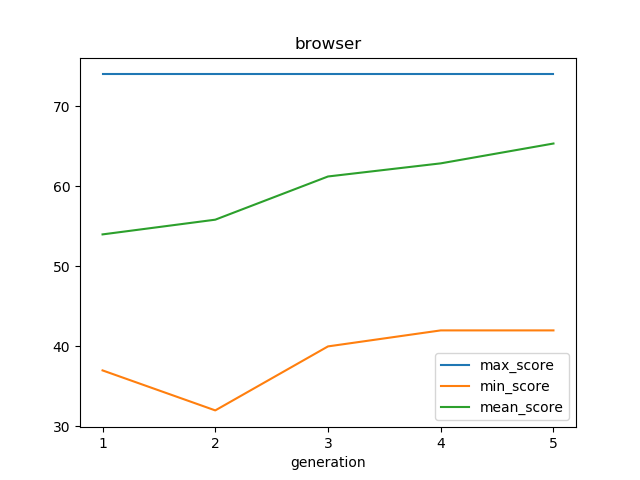

In [13]:
#Evolution Plot

from IPython.display import Image
plot_file = os.path.join(experiment_results_dir, 'experiment_stats.png')
Image(filename=plot_file)

In [14]:
#Load Best Candidate

last_generation = experiment_params["evolution"]["nb_generations"]
candidate_id_with_max_score = stats_df.iloc[experiment_params["evolution"]["nb_generations"] -1]["cid_max_score"]
max_score = stats_df.iloc[last_generation -1]["max_score"]
print('Best candidate is ',candidate_id_with_max_score,' with a score of ',max_score)

Best candidate is  5_25  with a score of  74.0


In [15]:
#Prescribe the actions based on the contexts from the saved model

best_model_filename = os.path.join(experiment_results_dir,
                                   str(last_generation),
                                   candidate_id_with_max_score + ".h5")
best_model = load_model(best_model_filename)
best_model.summary()


product = np.array([[1, 0]])
browser = np.array([[1, 0, 0]])
device_Resolution = np.array([[1, 0]])
region = np.array([[1, 0]])
windows_user = np.array([[1, 0, 0]])


prescription = best_model.predict([product,browser,device_Resolution,region,windows_user])
print("The raw Prescriptor model output is {}".format(prescription))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Product_input (InputLayer)      (None, 2)            0                                            
__________________________________________________________________________________________________
Browser_input (InputLayer)      (None, 3)            0                                            
__________________________________________________________________________________________________
Device Resolution_input (InputL (None, 2)            0                                            
__________________________________________________________________________________________________
Region_input (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
OS_input (